# Mosaic Integration of RNA+ADT

In this tutorial, we demonstrate how to use MIDAS to integrate a mosaic dataset consisting of paired and unpaired RNA (gene expression) and ADT (antibody-derived tags) data.

## 1. Setting Up the Environment

In [14]:
import os
import subprocess
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.io import mmread
from scipy.stats import pearsonr

from scmidas.config import load_config
from scmidas.data import download_data, download_models, download_script
from scmidas.model import MIDAS

os.environ['CUDA_VISIBLE_DEVICES']='0'  # Set the GPU device to be used
sc.set_figure_params(figsize=(4, 4))    # Set plotting parameters for scanpy
L.seed_everything(42)                   # Set a global random seed for reproducibility

Seed set to 42


42

## 2. Downloading the Data

We will use a multi-batch (8 batches) RNA+ADT mosaic dataset in mtx format.

In [ ]:
task = 'wnn_mosaic_8batch_mtx'
download_data(task)

## 3. Configuring the Model

In [16]:
configs = load_config()
configs['num_workers'] = 8  # Adjust based on your system's CPU cores for data loading
model = MIDAS.configure_data_from_dir(configs=configs, dir_path='dataset/'+task+'/data',
                                      save_model_path='saved_models/'+task)

INFO:root:The model is initialized with the default configurations.
INFO:root:Input data: 
         #CELL    #RNA   #ADT  #VALID_RNA  #VALID_ADT
BATCH 0   6378  3617.0    NaN      3617.0         NaN
BATCH 1   5899     NaN  224.0         NaN       224.0
BATCH 2   4628  3617.0  224.0      3617.0       224.0
BATCH 3   5285  3617.0  224.0      3617.0       224.0
BATCH 4   6952  3617.0    NaN      3617.0         NaN
BATCH 5   6060     NaN  224.0         NaN       224.0
BATCH 6   8854  3617.0  224.0      3617.0       224.0
BATCH 7   8908  3617.0  224.0      3617.0       224.0


## 4. Training the Model

In [ ]:
use_pretrained = True # To train from scratch, set it to False

if use_pretrained:
    download_models(task)
    model.load_checkpoint(f'saved_models/{task}.pt')
else:
    trainer = L.Trainer(max_epochs=2000)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    trainer.fit(model=model)

## 5. Generating Predictions

With a trained model, we can now perform inference.

### 5.1 Joint Embeddings, Imputed Data, and Batch-Corrected Data

In [ ]:
# `joint_latent=True`: Generate the joint embeddings.
# `impute=True`: Generate imputed count data, without batch-correction.
# `batch_correct=True`: Generate imputed and batch-corrected count data.
predicted_bc = model.predict(joint_latent=True, impute=True, batch_correct=True)

To validate the quality of the imputed data, we compute the Pearson correlation between the imputed data and the real data.

In [19]:
adt_real = mmread('dataset/'+task+'/ref_data/p1_0_adt.mtx').toarray()
id = predicted_bc['s']['joint'].flatten()==0
print('Pearson\'s r for imputed ADT in BATCH 0:', pearsonr(adt_real.reshape(-1), predicted_bc['x_impt']['adt'][id].reshape(-1))[0])

adt_real = mmread('dataset/'+task+'/ref_data/p5_0_adt.mtx').toarray()
id = predicted_bc['s']['joint'].flatten()==4
print('Pearson\'s r for imputed ADT in BATCH 4:', pearsonr(adt_real.reshape(-1), predicted_bc['x_impt']['adt'][id].reshape(-1))[0])

rna_real = mmread('dataset/'+task+'/ref_data/p2_0_rna.mtx').toarray()
id = predicted_bc['s']['joint'].flatten()==1
print('Pearson\'s r for imputed RNA in BATCH 1:', pearsonr(rna_real.reshape(-1), predicted_bc['x_impt']['rna'][id].reshape(-1))[0])

rna_real = mmread('dataset/'+task+'/ref_data/p6_0_rna.mtx').toarray()
id = predicted_bc['s']['joint'].flatten()==5
print('Pearson\'s r for imputed RNA in BATCH 5:', pearsonr(rna_real.reshape(-1), predicted_bc['x_impt']['rna'][id].reshape(-1))[0])

Pearson's r for imputed ADT in BATCH 0: 0.8741330259221722
Pearson's r for imputed ADT in BATCH 4: 0.8237828434393099
Pearson's r for imputed RNA in BATCH 1: 0.8661703620965506
Pearson's r for imputed RNA in BATCH 5: 0.9306409417919979


### 5.2 Modality-Specific Embeddings

We infer the embeddings for each data modality (RNA and ADT) separately.

In [ ]:
# `mod_latent=True`: Generate modality-specific embeddings.
# `group_by='batch'`: Organise the predictions by batch (for later use).
predicted_mod = model.predict(mod_latent=True, group_by='batch')

## 6. Visualizing the Results

First, we load the cell-type labels and batch identifiers for annotation.

In [21]:
label = []
batch_id = []
for i in [f'p{j}_0' for j in range(1,9)]:
    label.append(pd.read_csv('dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten())
    batch_id.append([i] * len(label[-1]))
labels = np.concatenate(label)
batch_ids = np.concatenate(batch_id)

### 6.1 Joint Embeddings

... storing 'batch' as categorical
... storing 'label' as categorical


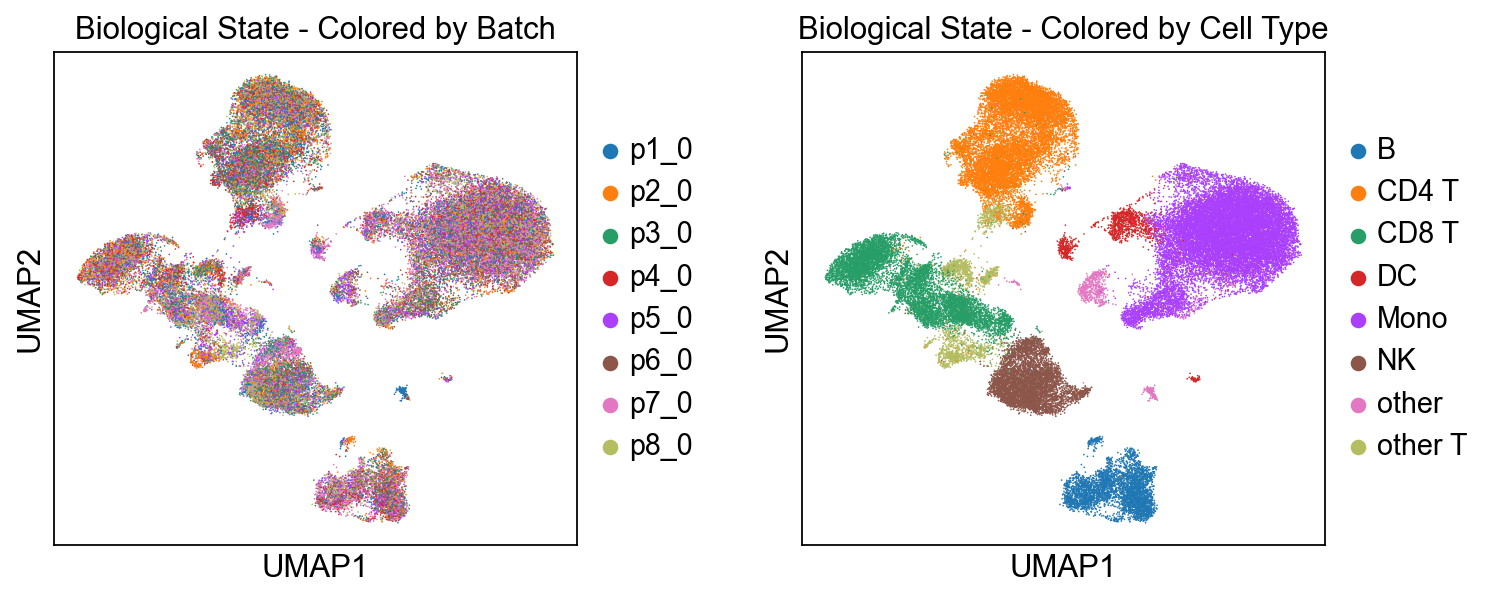

... storing 'batch' as categorical
... storing 'label' as categorical


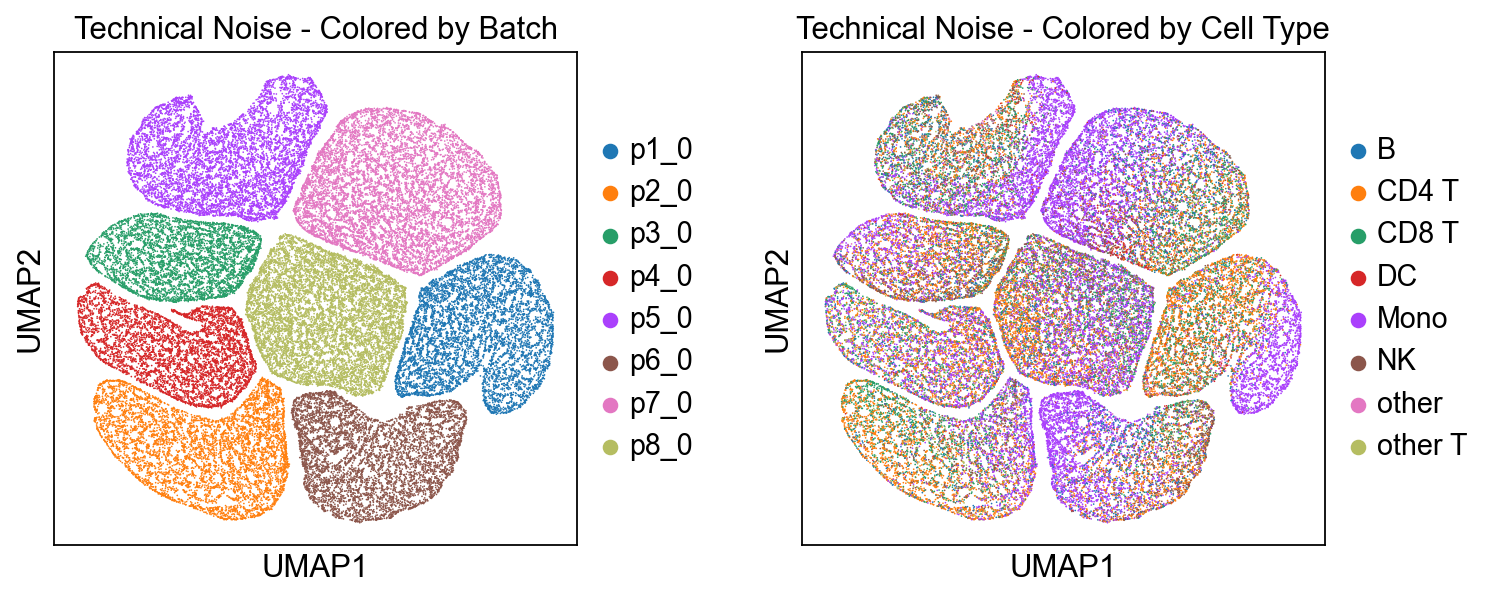

In [22]:
# Separate the biological and technical components of the joint embedding
z_joint = {"Biological State": sc.AnnData(predicted_bc['z']['joint'][:, :model.dim_c]),
           "Technical Noise": sc.AnnData(predicted_bc['z']['joint'][:, model.dim_c:])}

# Plot UMAP for each component
for k, adata in z_joint.items():
    adata.obs['batch'] = batch_ids
    adata.obs['label'] = labels
    sc.pp.subsample(adata, fraction=1)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['batch', 'label'], ncols=2, wspace=0.3,
               title=[f'{k} - Colored by Batch', f'{k} - Colored by Cell Type'])

### 6.2 Modality-Specific Embeddings

We visualize the biological embeddings (`c`) for each modality (RNA, ADT) and for the joint representation, across all 8 batches.

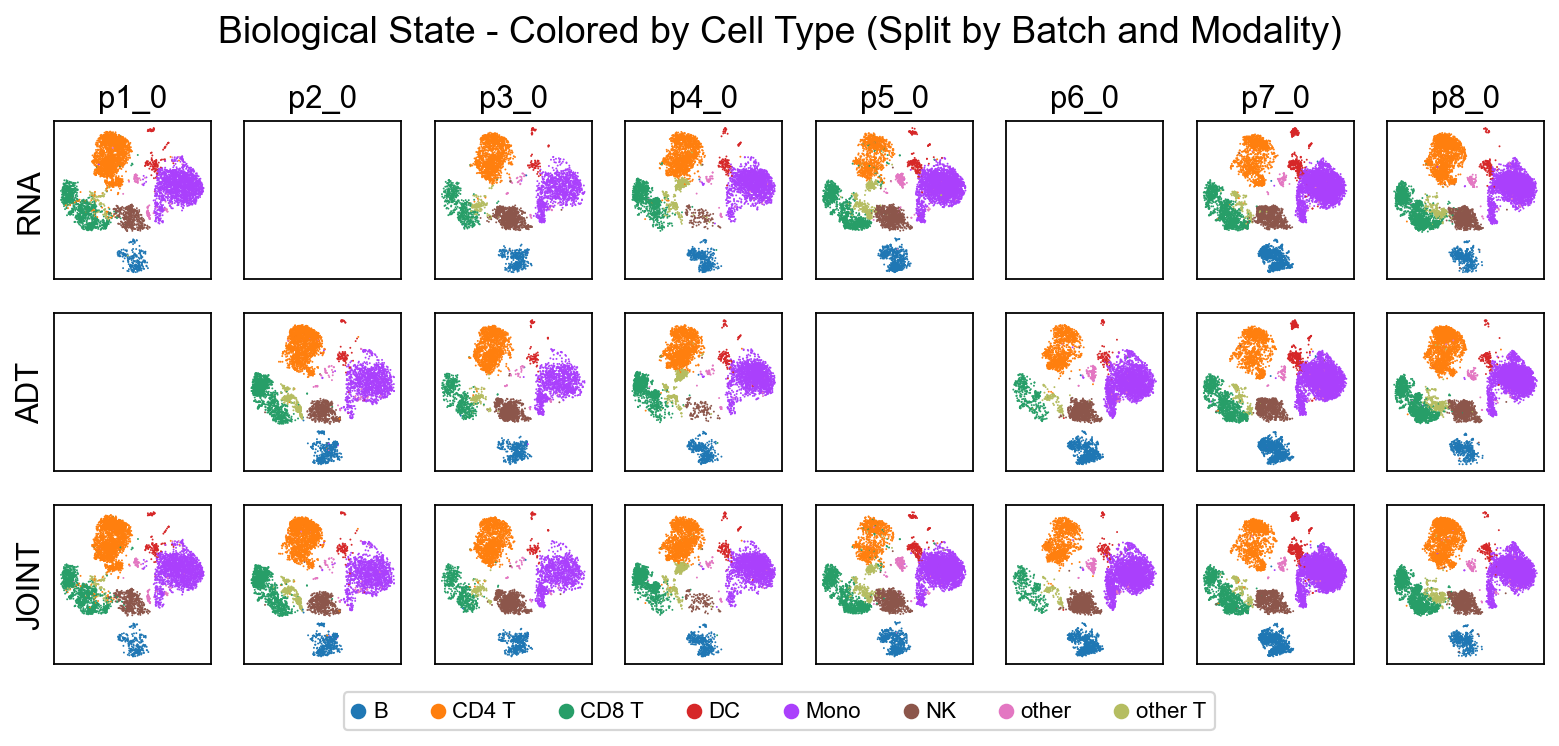

In [23]:
# Consolidate modality-specific embeddings into a single AnnData object for plotting
batch_names = [f'p{i}_0' for i in range(1,9)]
adata_dict = {}
for i in range(model.dims_s['joint']): # Iterate through batches
    for m in model.mods+['joint']: # Iterate through modalities (RNA, ADT, joint)
        if m in predicted_mod[i]['z']:
            # Create an AnnData object for the biological component of the latent space
            adata = sc.AnnData(predicted_mod[i]['z'][m][:, :model.dim_c])
            adata.obs['batch'] = batch_names[i]
            adata.obs['modality'] = m
            adata.obs['label'] = label[i]
            adata_dict[f"{batch_names[i]}_{m}"] = adata

# Concatenate all AnnData objects
adata_mod_concat = sc.concat(adata_dict, index_unique="-")
for col in adata_mod_concat.obs.columns:
    adata_mod_concat.obs[col] = adata_mod_concat.obs[col].astype('category')

# Compute neighbors and UMAP on the combined data
sc.pp.neighbors(adata_mod_concat, use_rep='X')
sc.pp.subsample(adata_mod_concat, fraction=1) # Shuffle data
sc.tl.umap(adata_mod_concat)

# Setup the figure for plotting
nrows = len(model.mods) + 1
ncols = model.dims_s['joint']
point_size = 3
fig, ax = plt.subplots(nrows, ncols, figsize=[1.45 * ncols, 1.45 * nrows])

# Iteratively create a UMAP scatter plot for each batch and modality
mod_names = model.mods + ['joint']
for i, mod in enumerate(mod_names):
    for b in range(model.dims_s['joint']):
        # Filter the data for the current modality and batch
        adata_subset = adata_mod_concat[
            (adata_mod_concat.obs['modality'] == mod) & 
            (adata_mod_concat.obs['batch'] == batch_names[b])
        ].copy()
        
        ax_current = ax[i, b]
        if len(adata_subset) > 0:
            sc.pl.umap(adata_subset, color='label', show=False, ax=ax_current, s=point_size, title="")
            ax_current.get_legend().set_visible(False)
            # Store legend handles from one of the plots to create a global legend
            if i == 0 and b == 0:
                handles, labels_ = ax_current.get_legend_handles_labels()
        
        # Clean up axes
        ax_current.set_xticks([])
        ax_current.set_yticks([])
        ax_current.set_xlabel('')
        
        # Set row and column titles
        if b == 0:
            ax_current.set_ylabel(mod.upper())
        else:
            ax_current.set_ylabel('')
        if i == 0:
            ax_current.set_title(batch_names[b])
        else:
            ax_current.set_title('')

# Create a single, global legend for the entire figure
fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels_), fontsize=10)
fig.suptitle("Biological State - Colored by Cell Type (Split by Batch and Modality)")
plt.tight_layout(rect=[0.07, 0, 0.93, 1.03])
plt.show()

### 6.3 Imputed and Batch-Corrected Data

We use WNN to compute joint embeddings from the imputed and batch-corrected counts.

For efficiency, we'll use a random sample of 2000 cells.

In [24]:
N = 2000
select = np.random.choice(list(range(len(predicted_bc['x_bc']['rna']))), N, replace=False)
adata = sc.AnnData(np.zeros([N, 1])) # Create a placeholder AnnData object for plotting

We subsample the imputed and batch-corrected data, save them to disk, execute the R script to perform WNN and UMAP, and then load and plot the results.

'wnn_bimodal.R' already exists. Skipping download.

Python: Executing R script 'wnn_bimodal.R' for Imputed and Batch-Corrected Data...



... storing 'label' as categorical
... storing 'batch' as categorical


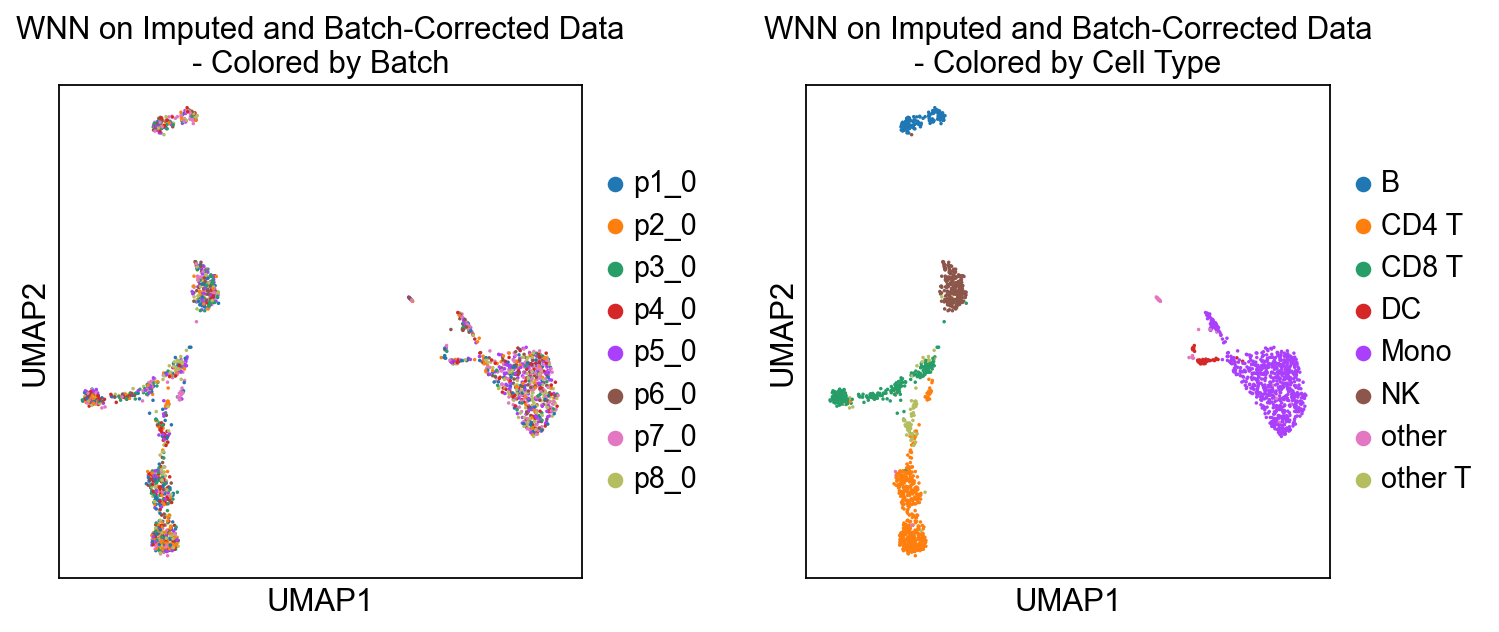

In [25]:
temp_dirs = {"Imputed and Batch-Corrected Data": 'demo2_temp/x_bc/'}
r_script_file = 'wnn_bimodal.R' # R script for WNN analysis on RNA+ADT data
download_script(r_script_file)

for name, temp_dir in temp_dirs.items():
    # 1. Save Python data to disk for the R script to access
    os.makedirs(temp_dir, exist_ok=True)
    data_key = Path(temp_dir).name  # 'x_bc' or 'x'
    pd.DataFrame(predicted_bc[data_key]['rna'][select]).T.to_csv(temp_dir+'rna.csv', index=True)
    pd.DataFrame(predicted_bc[data_key]['adt'][select]).T.to_csv(temp_dir+'adt.csv', index=True)

    # 2. Execute the R script via a subprocess
    print(f"\nPython: Executing R script '{r_script_file}' for {name}...\n")
    command = ['Rscript', '--vanilla', r_script_file, temp_dir]
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    # print(result.stdout) # uncomment this line to see the R script's output

    # 3. Load the UMAP results generated by R and plot them
    adata.obsm['X_umap'] = pd.read_csv(temp_dir+'umap_coords.csv', index_col=0).values
    adata.obs['label'] = labels[select]
    adata.obs['batch'] = batch_ids[select]
    sc.pp.subsample(adata, fraction=1) # Shuffle data
    sc.pl.umap(adata, color=['batch', 'label'], ncols=2, wspace=0.3, size=10,
               title=[f'WNN on {name}\n- Colored by Batch', f'WNN on {name}\n- Colored by Cell Type'])


This shows that MIDAS can produce imputed and batch-corrected data that is directly usable by standard downstream analysis tools like Seurat's WNN to achieve effective data integration.